In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
df = pd.read_csv('Nat_Gas.csv')

In [3]:
df.head()

,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


In [4]:

df.columns = ['date','price'] # renaming for easier use
df['date'] = pd.to_datetime(df['date'],format='%m/%d/%y') # converts from string to actual date and time format
df['price'] = df['price'].astype('float')

In [5]:
df.head()

,date,price
0,2020-10-31,10.1
1,2020-11-30,10.3
2,2020-12-31,11.0
3,2021-01-31,10.9
4,2021-02-28,10.9


In [6]:
df = df.sort_values('date')

In [7]:
df = df.set_index('date').asfreq('M')

C:\Users\anshb\AppData\Local\Temp\ipykernel_3784\1956298677.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.set_index('date').asfreq('M')


In [8]:
df.head()

,price
date,
2020-10-31,10.1
2020-11-30,10.3
2020-12-31,11.0
2021-01-31,10.9
2021-02-28,10.9


In [9]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# -----------------------------------------------------
# STEP 2: Fit Holt-Winters model (captures trend + seasonality)
# -----------------------------------------------------
model = ExponentialSmoothing(df['price'], trend='add', seasonal='add', seasonal_periods=12)
fit = model.fit(optimized=True)

In [10]:
forcast_steps = 12
forcast = fit.forecast(forcast_steps)
forcast_dates = pd.date_range(df.index[-1]+pd.offsets.MonthEnd(1),periods=forcast_steps,freq='M')
forcast_df = pd.DataFrame({'date':forcast_dates,'focast_price':forcast.values})

C:\Users\anshb\AppData\Local\Temp\ipykernel_3784\1795964677.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forcast_dates = pd.date_range(df.index[-1]+pd.offsets.MonthEnd(1),periods=forcast_steps,freq='M')


In [11]:
def estimate_price_any_date(input_date):
    date = pd.to_datetime(input_date)
    # they are needed to check if input date lies between the range that we have
    first_date = df.index[0]
    last_date = df.index[-1]
    '''Interpolation estimates the price on 15th August by smoothly averaging nearby month-end prices.
    So you get a fractional value, not just the nearest months price.'''
    if first_date<=date<=last_date:
        s=df['price']
        price = float(s.reindex(s.index.union([date])).interpolate('time').loc['date'])
        return price
    elif date > last_date:
        months_ahead = ((date.year - last_date.year)*12 + (date.month-last_date.month))
        pred = fit.forcast(months_ahead+1)
        return float(pred.iloc[-1])
    else:
        months_back = ((first_date.year - date.year)*12 + (first_date.month-date.month))
        pred  = fit.predict(start=-months_back,end=-months_back )
        return float(pred.iloc[0])
    

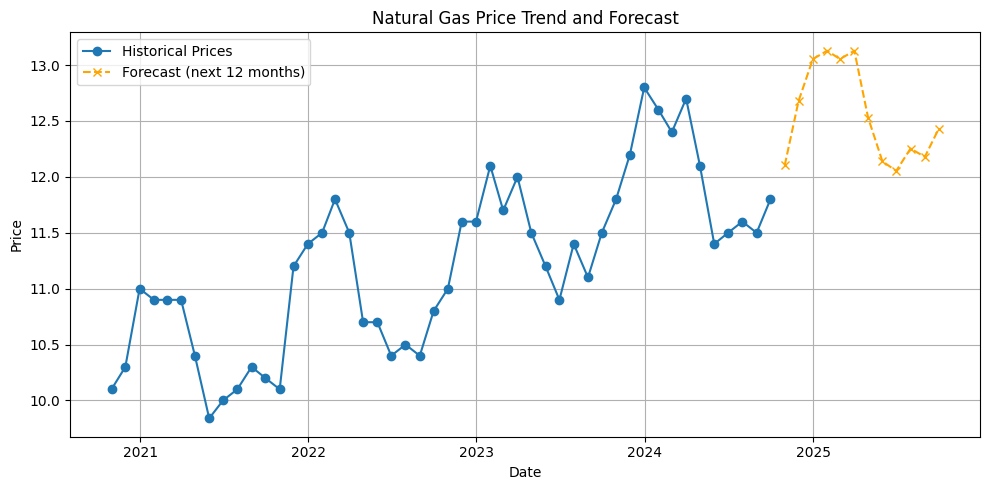

In [12]:
plt.figure(figsize=(10,5))
plt.plot(df.index, df['price'], label='Historical Prices', marker='o')
plt.plot(forcast_dates, forcast, label='Forecast (next 12 months)', marker='x', linestyle='--', color='orange')
plt.title('Natural Gas Price Trend and Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
def price_for_storing(inject_date,withdraw_date,
                      inject_rate,withdraw_rate,
                      max_vol,storage_cost_per_unit,
                      df_prices):
    curr_volume = 0 
    net_value = 0
    
    price_series = df_prices.set_index('date')['price']

    inject_date = sorted(pd.to_datetime(inject_date))
    withdraw_date = sorted(pd.to_datetime(withdraw_date))

    for date in inject_date:
        price = price_series.asof(date) # this takes the nearest past price 
        # around that date
        inject_vol = min(inject_rate,max_vol-curr_volume)
        net_value -= inject_vol * price
        curr_volume += inject_vol
        net_value -= inject_vol * storage_cost_per_unit

    for date in withdraw_date:
        price = price_series.asof(date)
        withdraw_vol = min(withdraw_rate,curr_volume)
        net_value += withdraw_vol * price
        curr_volume -= withdraw_vol
        net_value -= withdraw_vol * storage_cost_per_unit

    return net_value 

In [14]:
dates = pd.date_range('2024-01-31', '2024-06-30', freq='M')
prices = [10.0, 10.5, 10.2, 10.8, 11.0, 11.2]
df_prices = pd.DataFrame({'date': dates, 'price': prices})

inject_date = ['2024-01-31', '2024-02-29', '2024-03-31']
withdraw_date = ['2024-04-30', '2024-05-31', '2024-06-30']

contract_value = price_for_storing(
    inject_date, withdraw_date,
    inject_rate=1000, withdraw_rate=1000,
    max_vol=3000, storage_cost_per_unit=0.05,
    df_prices=df_prices
)

print(f"Net value of the storage contract: {contract_value:.2f}")

Net value of the storage contract: 2000.00


C:\Users\anshb\AppData\Local\Temp\ipykernel_3784\67280146.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range('2024-01-31', '2024-06-30', freq='M')


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report
import lightgbm as lgb


In [16]:
# Load dataset
df = pd.read_csv('Task_3_and_4_Loan_Data.csv')
df.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [17]:
X = df.drop(columns=['customer_id', 'default']) # not disregarding default but 
# we are using it as labels
y = df['default']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [18]:
train_data = lgb.Dataset(X_train,label=y_train)
test_data = lgb.Dataset(X_test,label=y_test)

In [19]:
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.metrics import roc_auc_score

model = LGBMClassifier(
    objective='binary',
    learning_rate=0.05,
    num_leaves=31,
    feature_fraction=0.9,
    bagging_fraction=0.8,
    bagging_freq=5,
    n_estimators=200,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='auc',
    callbacks=[early_stopping(30), log_evaluation(50)]  
)

pd_pred = model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, pd_pred)
print("ROC-AUC:", round(auc, 4))


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 1481, number of negative: 6519
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1039
[LightGBM] [Info] Number of data poin

c:\Users\anshb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [20]:
recovery_rate = 0.1

# Find column position
col_idx = df.columns.get_loc('loan_amt_outstanding')
loan_amt_test = df.iloc[y_test.index,col_idx]
expected_loss_test = pd_pred * (1-recovery_rate) * loan_amt_test

results = pd.DataFrame({
    'loan_amt' : loan_amt_test,
    'prediction' : pd_pred,
    'expected_loss' : expected_loss_test
})
results.head()

,loan_amt,prediction,expected_loss
1187,3751.658863,0.000391,1.319562
2054,4377.267759,0.000473,1.862214
6099,4921.822166,0.000401,1.778374
7015,3606.449724,0.000391,1.268488
3119,2441.035518,0.000388,0.852952


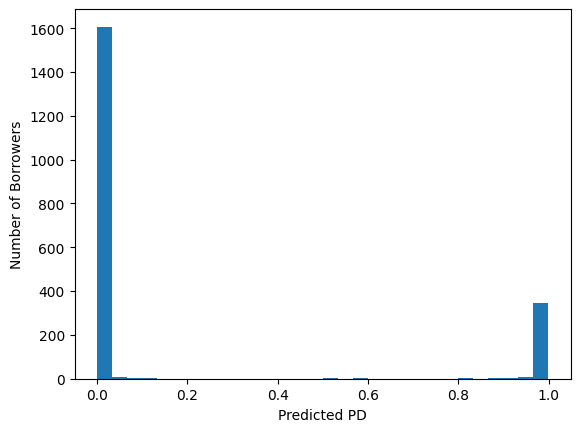

In [21]:
import matplotlib.pyplot as plt
plt.hist(results['prediction'], bins=30)
plt.xlabel("Predicted PD")
plt.ylabel("Number of Borrowers")
plt.show()


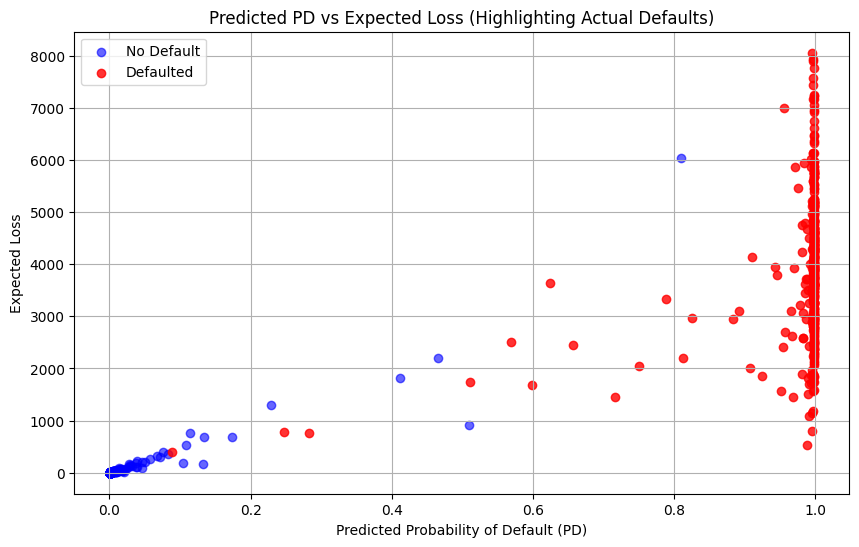

In [23]:
import matplotlib.pyplot as plt

results['actual_default'] = y_test.values

plt.figure(figsize=(10,6))

# plot non defaulters
plt.scatter(
    results[results['actual_default']==0]['prediction'],
    results[results['actual_default']==0]['expected_loss'],
    color='blue', alpha=0.6, label='No Default'
)

# plot defaulters
plt.scatter(
    results[results['actual_default']==1]['prediction'],
    results[results['actual_default']==1]['expected_loss'],
    color='red', alpha=0.8, label='Defaulted'
)

plt.title("Predicted PD vs Expected Loss (Highlighting Actual Defaults)")
plt.xlabel("Predicted Probability of Default (PD)")
plt.ylabel("Expected Loss")
plt.legend()
plt.grid(True)
plt.show()


In [24]:
results[results['actual_default']==0]['prediction'].head()

1187    0.000391
2054    0.000473
6099    0.000401
7015    0.000391
3119    0.000388
Name: prediction, dtype: float64

In [25]:
# Annotate top 5 riskiest loans by Expected Loss
top5 = results.nlargest(5, 'expected_loss')
top5.head()

,loan_amt,prediction,expected_loss,actual_default
9944,8989.178801,0.995952,8057.509060,1
5460,8841.923630,0.997364,7936.755114,1
6364,8802.265206,0.997522,7902.411053,1
346,8638.366979,0.998115,7759.875717,1
7475,8427.592750,0.997464,7565.598699,1


In [34]:
from sklearn.cluster import KMeans
df.head()
fico_scores = df[['fico_score']].values
# kmeans requires 2d arr , thus we have reshaped

n_buckets = 5

kmeans = KMeans(n_clusters=n_buckets,random_state=42)
df['bucket'] = kmeans.fit_predict(fico_scores)

In [44]:
bucket_means = df.groupby('bucket')['fico_score'].mean().sort_values(ascending=False)
rating_map = {bucket : i+1 for i,bucket in enumerate(bucket_means.index)}
df['rating'] = df['bucket'].map(rating_map)

In [45]:
df.head(10)

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default,bucket,rating
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0,0,4
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1,0,4
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0,0,4
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0,0,4
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0,1,3
5,4661159,0,5376.886873,7189.121298,85529.84591,2,697,0,2,2
6,8291909,1,3634.057471,7085.980095,68691.57707,6,722,0,4,1
7,4616950,4,3302.172238,13067.570210,50352.16821,3,545,1,3,5
8,3395789,0,2938.325123,1918.404472,53497.37754,4,676,0,2,2
9,4045948,0,5396.366774,5298.824524,92349.55399,2,447,0,3,5
